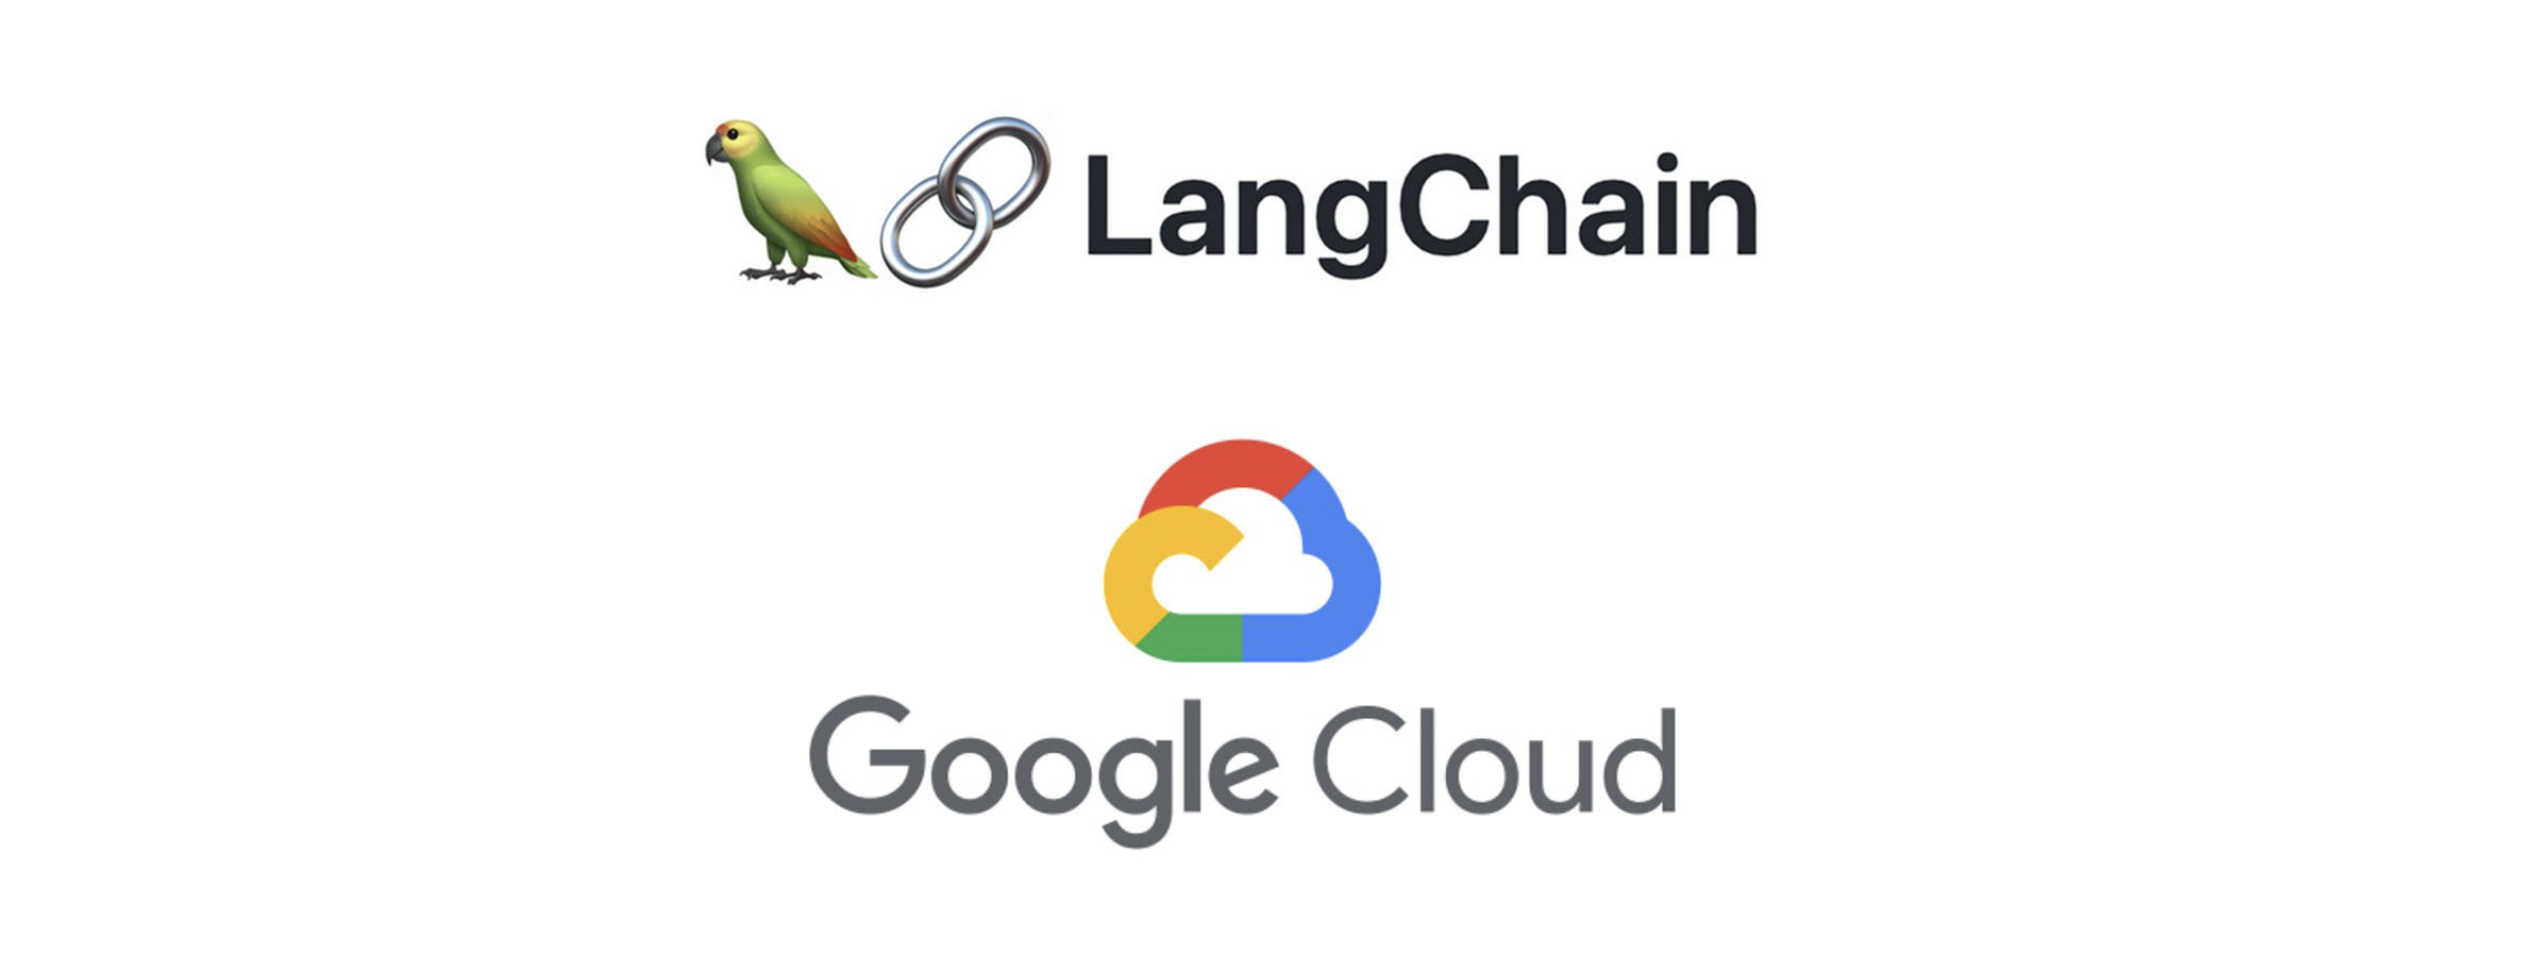

In [1]:
# Install dependencies
!pip install asyncio==3.4.3 asyncpg==0.27.0 cloud-sql-python-connector["asyncpg"]==1.2.3

In [2]:
!pip install numpy==1.22.4 pandas==1.5.3

In [3]:
!pip install pgvector==0.1.8

In [4]:
!pip install langchain==0.0.196 transformers==4.30.1

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.20 requires pydantic>=2.7.0, but you have pydantic 1.10.9 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
langchain-community 0.3.14 requires langchain<0.4.0,>=0.3.14, but you have langchain 0.0.196 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which 

In [5]:
!pip install google-cloud-aiplatform==1.26.0

  Using cached Shapely-1.8.5.post1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (43 kB)
Using cached Shapely-1.8.5.post1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.0 MB)
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.6
    Uninstalling shapely-2.0.6:
      Successfully uninstalled shapely-2.0.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geopandas 1.0.1 requires shapely>=2.0.0, but you have shapely 1.8.5.post1 which is incompatible.


In [6]:
pip install --upgrade shapely

  Using cached shapely-2.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached shapely-2.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.26.0 requires shapely<2.0.0, but you have shapely 2.0.6 which is incompatible.


In [7]:
#from langchain.llms import OpenAI

In [7]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Setup Google Cloud environment


---



In [1]:
# @markdown Replace the required placeholder text below. You can modify any other default values, if you like.

# Please fill in these values.
project_id = ""  # @param {type:"string"}
database_password = ""  # @param {type:"string"}
region = "us-west2"  # @param {type:"string"}
instance_name = "pg15-pgvector-demo"  # @param {type:"string"}
database_name = "retail"  # @param {type:"string"}
database_user = "retail-admin"  # @param {type:"string"}


# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"
assert region, "⚠️ Please provide a Google Cloud region"
assert instance_name, "⚠️ Please provide the name of your instance"
assert database_name, "⚠️ Please provide a database name"
assert database_user, "⚠️ Please provide a database user"
assert database_password, "⚠️ Please provide a database password"

## Authenticate your Google Cloud Account and enable APIs.


---



In [2]:
# Authenticate your Google Cloud Account and enable APIs.
# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {project_id}

# Grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding {project_id} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"


# Enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com
!gcloud services enable aiplatform.googleapis.com

Updated property [core/project].
Updated IAM policy for project [aiproject-447322].
bindings:
- members:
  - serviceAccount:service-296523582024@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:service-296523582024@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.user
- members:
  - user:mansimore5m@gmail.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service-296523582024@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:service-296523582024@dataflow-service-producer-prod.iam.gserviceaccount.com
  role: roles/dataflow.serviceAgent
- members:
  - serviceAccount:296523582024-compute@developer.gserviceaccount.com
  - serviceAccount:296523582024@cloudservices.gserviceaccount.com
  role: roles/editor
- members:
  - serviceAccount:service-296523582024@gcp-sa-notebooks.iam.gserviceaccount.com
  role: roles/notebooks.serviceAgent
- members:
  - u

## Setup Cloud SQL instance and PostgreSQL database


---



Create and setup a Cloud SQL PostgreSQL instance, if not done already.

In [3]:
#@markdown Create and setup a Cloud SQL PostgreSQL instance, if not done already.
database_version = !gcloud sql instances describe {instance_name} --format="value(databaseVersion)"
if database_version[0].startswith("POSTGRES"):
  print("Found an existing Postgres Cloud SQL Instance!")
else:
  print("Creating new Cloud SQL instance...")
  !gcloud sql instances create {instance_name} --database-version=POSTGRES_15 \
    --region={region} --cpu=1 --memory=4GB --root-password={database_password}

# Create the database, if it does not exist.
out = !gcloud sql databases list --instance={instance_name} --filter="NAME:{database_name}" --format="value(NAME)"
if ''.join(out) == database_name:
  print("Database %s already exists, skipping creation." % database_name)
else:
  !gcloud sql databases create {database_name} --instance={instance_name}

# Create the database user for accessing the database.
!gcloud sql users create {database_user} \
  --instance={instance_name} \
  --password={database_password}


Found an existing Postgres Cloud SQL Instance!
Database retail already exists, skipping creation.
Created user [retail-admin].


### Verify that you are able to connect to the database. Executing this block should print the current PostgreSQL server version.


---



In [4]:
# Verify that you are able to connect to the database. Executing this block should print the current PostgreSQL server version.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    # get current running event loop to be used with Connector
    loop = asyncio.get_running_loop()
    # initialize Connector object as async context manager
    async with Connector(loop=loop) as connector:
        # create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}"
            # ... additional database driver args
        )

        # query Cloud SQL database
        results = await conn.fetch("SELECT version()")
        print(results[0]["version"])

        # close asyncpg connection
        await conn.close()


# Test connection with `asyncio`
await main()  # type: ignore

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/instance.py:330: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


PostgreSQL 15.10 on x86_64-pc-linux-gnu, compiled by Debian clang version 12.0.1, 64-bit


## Prepare data


---



#### Download and load the dataset in PostgreSQL

In [5]:
# Load dataset from a web URL and store it in a pandas dataframe.

import pandas as pd
import os

DATASET_URL = "https://github.com/GoogleCloudPlatform/python-docs-samples/raw/main/cloud-sql/postgres/pgvector/data/retail_toy_dataset.csv"
df = pd.read_csv(DATASET_URL)
df = df.loc[:, ["product_id", "product_name", "description", "list_price"]]
df = df.dropna()
df.head(10)

,product_id,product_name,description,list_price
0,7e8697b5b7cdb5a40daf54caf1435cd5,"Koplow Games Set of 2 D12 12-Sided Rock, Paper...","Rock, paper, scissors is a great way to resolv...",3.56
1,7de8b315b3cb91f3680eb5b88a20dcee,"12""-20"" Schwinn Training Wheels",Turn any small bicycle into an instrument for ...,28.17
2,fb9535c103d7d717f0414b2b111cfaaa,Bicycle Pinochle Jumbo Index Playing Cards - 1...,Purchase includes 1 blue deck and 1 red deck. ...,6.49
3,c73ea622b3be6a3ffa3b0b5490e4929e,Step2 Woodland Adventure Playhouse & Slide,The Step2 Woodland Climber Adventure Playhouse...,499.99
4,dec7bd1f983887650715c6fafaa5b593,Step2 Naturally Playful Welcome Home Playhouse...,Children can play and explore in the Step2 Nat...,600.00
5,74a695e3675efc2aad11ed73c46db29b,Slip N Slide Triple Racer with Slide Boogies,Triple Racer Slip and Slide with Boogie Boards...,37.21
6,3eae5293b56c25f63b47cb8a89fb4813,Hydro Tools Digital Pool/Spa Thermometer,The solar-powered Swimline Floating Digital Th...,15.92
7,ed85bf829a36c67042503ffd9b6ab475,Full Bucket Swing With Coated Chain Toddler Sw...,Safe Kids&Children Full Bucket Swing With Coa...,102.26
8,55820fa53f0583cb637d5cb2b051d78c,Banzai Water Park Splash Zone,Dive into fun in your own backyard with the B...,397.82
9,0e26a9e92e4036bfaa68eb2040a8ec97,Polaris 39-310 5-Liter Zippered Super Bag for ...,Keep your pool water sparkling clean all seaso...,39.47


In [6]:
df = df.head(50)
df.shape

(50, 4)

In [7]:
# Save the Pandas dataframe in a PostgreSQL table.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("DROP TABLE IF EXISTS products CASCADE")
        # Create the `products` table.
        await conn.execute(
            """CREATE TABLE products(
                                product_id VARCHAR(1024) PRIMARY KEY,
                                product_name TEXT,
                                description TEXT,
                                list_price NUMERIC)"""
        )

        # Copy the dataframe to the `products` table.
        tuples = list(df.itertuples(index=False))
        await conn.copy_records_to_table(
            "products", records=tuples, columns=list(df), timeout=10
        )
        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/instance.py:330: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


## Vector Embeddings


---



### Generate vector embeddings using a Text Embedding model


---



Step 1: Split long product description text into smaller chunks

- The product descriptions can be much longer than what can fit into a single API request for generating the vector embedding.

- For example, Vertex AI text embedding model accepts a maximum of 3,072 input tokens for a single API request.

- Use the `RecursiveCharacterTextSplitter` from LangChain library to split
the description into smaller chunks of 500 characters each.

In [8]:
# Split long text descriptions into smaller chunks that can fit into
# the API request size limit, as expected by the LLM providers.

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[".", "\n"],
    chunk_size=500,
    chunk_overlap=0,
    length_function=len,
)
chunked = []
for index, row in df.iterrows():
    product_id = row["product_id"]
    desc = row["description"]
    splits = text_splitter.create_documents([desc])
    for s in splits:
        r = {"product_id": product_id, "content": s.page_content}
        chunked.append(r)

Step 2: Generate vector embedding for each chunk by calling an Embedding Generation service

- Vertex AI text embedding model is used to generate vector embeddings, which outputs a 768-dimensional vector for each chunk of text.


In [9]:
# Generate the vector embeddings for each chunk of text.
# This code snippet may run for a few minutes.

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform
import time

aiplatform.init(project=f"{project_id}", location=f"{region}")
embeddings_service = VertexAIEmbeddings()


# Helper function to retry failed API requests with exponential backoff.
def retry_with_backoff(func, *args, retry_delay=20, backoff_factor=2, **kwargs):
    max_attempts = 10
    retries = 0
    for i in range(max_attempts):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"error: {e}")
            retries += 1
            wait = retry_delay * (backoff_factor**retries)
            print(f"Retry after waiting for {wait} seconds...")
            time.sleep(wait)


batch_size = 2
for i in range(0, len(chunked), batch_size):
    request = [x["content"] for x in chunked[i : i + batch_size]]
    response = retry_with_backoff(embeddings_service.embed_documents, request)
    # Store the retrieved vector embeddings for each chunk back.
    for x, e in zip(chunked[i : i + batch_size], response):
        x["embedding"] = e

# Store the generated embeddings in a pandas dataframe.
product_embeddings = pd.DataFrame(chunked)
product_embeddings.head()

error: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: textembedding-gecko. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.
Retry after waiting for 40 seconds...
error: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: textembedding-gecko. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.
Retry after waiting for 80 seconds...
error: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: textembedding-gecko. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.
Retry after waiting for 40 seconds...
error: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: textembedding-gecko. Please submit a qu

,product_id,content,embedding
0,7e8697b5b7cdb5a40daf54caf1435cd5,"Rock, paper, scissors is a great way to resolv...","[0.040036752820014954, -0.025681596249341965, ..."
1,7e8697b5b7cdb5a40daf54caf1435cd5,"games, creating your own game, and friends and...","[0.01725427247583866, -0.002125497441738844, -..."
2,7de8b315b3cb91f3680eb5b88a20dcee,Turn any small bicycle into an instrument for ...,"[-0.004991121590137482, -0.06028855964541435, ..."
3,7de8b315b3cb91f3680eb5b88a20dcee,teel brackets stand up to heavy use. Customiza...,"[0.00582809979096055, -0.056259434670209885, 0..."
4,7de8b315b3cb91f3680eb5b88a20dcee,es.com. Follow ride Schwinn on: Twitter. Faceb...,"[0.0065319109708070755, -0.05318767577409744, ..."


### Use pgvector to store the generated embeddings within PostgreSQL

- The `pgvector` extension introduces a new `vector` data type.
- **The new `vector` data type allows you to directly save a vector embedding (represented as a NumPy array) through a simple INSERT statement in PostgreSQL!**

>⚠️ The following code snippet may run for a few minutes.

In [10]:
# Store the generated vector embeddings in a PostgreSQL table.
# This code may run for a few minutes.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
import numpy as np
from pgvector.asyncpg import register_vector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
        await register_vector(conn)

        await conn.execute("DROP TABLE IF EXISTS product_embeddings")
        # Create the `product_embeddings` table to store vector embeddings.
        await conn.execute(
            """CREATE TABLE product_embeddings(
                                product_id VARCHAR(1024) NOT NULL REFERENCES products(product_id),
                                content TEXT,
                                embedding vector(768))"""
        )

        # Store all the generated embeddings back into the database.
        for index, row in product_embeddings.iterrows():
            await conn.execute(
                "INSERT INTO product_embeddings (product_id, content, embedding) VALUES ($1, $2, $3)",
                row["product_id"],
                row["content"],
                np.array(row["embedding"]),
            )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/instance.py:330: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


### Demo: Finding similar products using pgvector cosine search operator

In [ ]:
!pip install -U langchain-community

In [11]:
# @markdown Enter a short description of the toy to search for within a specified price range:
toy = "Fire truck toy"  # @param {type:"string"}
min_price = 25  # @param {type:"integer"}
max_price = 100  # @param {type:"integer"}

# Quick input validations.
assert toy, "⚠️ Please input a valid input search text"

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform

aiplatform.init(project=f"{project_id}", location=f"{region}")

embeddings_service = VertexAIEmbeddings()
qe = embeddings_service.embed_query([toy])
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.1
        num_matches = 50

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $1) > $2
                              ORDER BY similarity DESC
                              LIMIT $3
                            )
                            SELECT product_name, list_price, description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            AND list_price >= $4 AND list_price <= $5
                            """,
            qe,
            similarity_threshold,
            num_matches,
            min_price,
            max_price,
        )

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            # Collect the description for all the matched similar toy products.
            matches.append(
                {
                    "product_name": r["product_name"],
                    "description": r["description"],
                    "list_price": round(r["list_price"], 2),
                }
            )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

# Show the results for similar products that matched the user query.
matches = pd.DataFrame(matches)
matches.head(5)

,product_name,description,list_price
0,"12""-20"" Schwinn Training Wheels",Turn any small bicycle into an instrument for ...,28.17
1,Slip N Slide Triple Racer with Slide Boogies,Triple Racer Slip and Slide with Boogie Boards...,37.21
2,Sandbox Castle 2-in-1 Sand and Water Table wit...,Package Includes Sandbox Castle 2-in-1 Sand an...,60.49
3,GIZMO Snow Tube,GIZMO?s exclusive snowmobile design features a...,27.99
4,DDI 2328072 2 Assorted Solid Colored Bath Brus...,Solid Colored Bath Brush features white soft ...,36.48
